In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from ipywidgets import interact, interactive, fixed, interact_manual

In [3]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/module_5_auto.csv"

dataset = pd.read_csv(url) 

dataset.head()

,Unnamed: 0.1,Unnamed: 0,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,...,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,0,0,3,122,alfa-romero,std,two,convertible,rwd,front,...,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,1,1,3,122,alfa-romero,std,two,convertible,rwd,front,...,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,2,2,1,122,alfa-romero,std,two,hatchback,rwd,front,...,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,3,3,2,164,audi,std,four,sedan,fwd,front,...,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,4,4,2,164,audi,std,four,sedan,4wd,front,...,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


#### Get only the numeric data

In [8]:
df = dataset.select_dtypes(include=[np.number, np.float64])

#  remove the columns 'Unnamed:0.1' and 'Unnamed:0' since they do not provide any value to the models.
df.drop(["Unnamed: 0.1", 'Unnamed: 0'], axis=1, inplace=True)

df.head()


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


### Functions for Plotting

In [9]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    ax1 = sns.kdeplot(RedFunction, color="r", label=RedName)
    ax2 = sns.kdeplot(BlueFunction, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    plt.show()
    plt.close()

In [10]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

# Part 1: Training and Testing
<p>An important step in testing your model is to split your data into training and testing data. We will place the target data <b>price</b> in a separate dataframe <b>y_data</b>:</p>

In [11]:
y_data = df['price']
y_data

0      13495.0
1      16500.0
2      16500.0
3      13950.0
4      17450.0
        ...   
196    16845.0
197    19045.0
198    21485.0
199    22470.0
200    22625.0
Name: price, Length: 201, dtype: float64

In [12]:
# Drop price data from x_data
x_data = df.drop('price', axis=1)

x_data.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,city-L/100km,diesel,gas
0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,11.190476,0,1
1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,11.190476,0,1
2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,12.368421,0,1
3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,9.791667,0,1
4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,13.055556,0,1


#### Now, we randomly split our data into training and testing data using the function <b>train_test_split</b>.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 21
number of training samples: 180


In [17]:
x_test.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,city-L/100km,diesel,gas
97,0,106,97.2,0.833253,0.905556,54.7,2302,120,3.33,3.47,8.5,97.0,5200.0,27,34,8.703704,0,1
117,1,154,93.7,0.755887,0.886111,50.6,1967,90,2.97,3.23,9.4,68.0,5500.0,31,38,7.580645,0,1
59,0,115,98.8,0.854397,0.923611,55.5,2410,122,3.39,3.39,8.6,84.0,4800.0,26,32,9.038462,0,1
35,0,78,96.5,0.754926,0.887500,58.3,2024,92,2.92,3.41,9.2,76.0,6000.0,30,34,7.833333,0,1
165,2,134,98.4,0.846708,0.911111,52.0,2551,146,3.62,3.50,9.3,116.0,4800.0,24,30,9.791667,0,1


In [18]:
x_train.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,city-L/100km,diesel,gas
159,1,168,94.5,0.810668,0.888889,52.6,2169,98,3.19,3.03,9.0,70.0,4800.0,29,34,8.103448,0,1
16,0,122,110.0,0.946660,0.984722,56.3,3505,209,3.62,3.39,8.0,182.0,5400.0,15,20,15.666667,0,1
108,0,161,107.9,0.897165,0.950000,56.7,3075,120,3.46,2.19,8.4,95.0,5000.0,19,24,12.368421,0,1
31,1,101,93.7,0.720807,0.888889,52.6,1837,79,2.91,3.07,10.1,60.0,5500.0,38,42,6.184211,0,1
44,0,145,113.0,0.959154,0.966667,52.8,4066,258,3.63,4.17,8.1,176.0,4750.0,15,19,15.666667,0,1


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #1):</h1>

<b>Use the function "train_test_split" to split up the dataset such that 40% of the data samples will be utilized for testing. Set the parameter "random_state" equal to zero. The output of the function should be the following:  "x_train1" , "x_test1", "y_train1" and  "y_test1".</b>

</div>

In [23]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.40, random_state=0)

print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])

number of test samples : 81
number of training samples: 120


### Let's import LinearRegression from the module linear_model.

In [28]:
# Create Linear Regression Object
lre = LinearRegression()

# Fit the model using the feature "horsepower"
lre.fit(x_train[['horsepower']], y_train)

# Calculate the R^2 on the test and train data
r2_X_test = lre.score(x_test[['horsepower']], y_test)
r2_X_train = lre.score(x_train[['horsepower']], y_train)

print("R^2 for testing data: ", r2_X_test)
print("R^2 for training data: ", r2_X_train)

R^2 for testing data:  0.36358755750788263
R^2 for training data:  0.6619724197515104


#### Summary

We can see the R^2 is much smaller using the test data compared to the training data.

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #2): </h1>
<b> 
Find the R^2  on the test data using 40% of the dataset for testing.
</b>
</div>

In [30]:
lre1 = LinearRegression()

# fit / train model
lre1.fit(x_train1[['horsepower']], y_train1)

# R^2
lre1.score(x_test1[['horsepower']], y_test1)

0.7139364665406973

Sometimes you do not have sufficient testing data; as a result, you may want to perform cross-validation. Let's go over several methods that you can use for cross-validation.

# Cross-Validation Score

We input the object, the feature ("horsepower"), and the target data (y_data). The parameter 'cv' determines the number of folds. In this case, it is 4.

In [32]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])


We can calculate the average and standard deviation of our estimate:

In [33]:
print("The mean of the folds are: ", Rcross.mean(), "\nStandard deviation: ", Rcross.std())

The mean of the folds are:  0.522009915042119 
Standard deviation:  0.2911839444756029


We can use negative squared error as a score by setting the parameter 'scoring' metric to 'neg_mean_squared_error'.

In [34]:
-1 * cross_val_score(lre, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')

array([20254142.84026703, 43745493.2650517 , 12539630.34014931,
       17561927.7224759 ])

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #3): </h1>
<b> 
Calculate the average R^2 using two folds, then find the average R^2 for the second fold utilizing the "horsepower" feature: 
</b>
</div>


In [35]:
Rc = cross_val_score(lre, x_data[['horsepower']], y_data, cv = 2) 

Rc.mean()

0.5166761697127429


You can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, with one fold for testing and the other folds are used for training. First, import the function:

We input the object, the feature "horsepower", and the target data y_data. The parameter 'cv' determines the number of folds. In this case, it is 4. We can produce an output:

In [37]:
yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv=4) 
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

# Part 2: Overfitting, Underfitting and Model Selection

<p>It turns out that the test data, sometimes referred to as the "out of sample data", is a much better measure of how well your model performs in the real world.  One reason for this is overfitting.

Let's go over some examples. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.</p>

Let's create Multiple Linear Regression objects and train the model using <b>'horsepower'</b>, <b>'curb-weight'</b>, <b>'engine-size'</b> and <b>'highway-mpg'</b> as features.

In [43]:
lr = LinearRegression()

# fit / train model
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

# Predict using training data
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
# Predict using test data
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

yhat_train[:5], yhat_test[:5]

(array([ 7426.6731551 , 28323.75090803, 14213.38819709,  4052.34146983,
        34500.19124244]),
 array([11349.35089149,  5884.11059106, 11208.6928275 ,  6641.07786278,
        15565.79920282]))

#### Model Evaluation
Let's perform some model evaluation using our training and testing data separately. First, we import the seaborn and matplotlib library for plotting.

Let's examine the distribution of the predicted values of the training data.

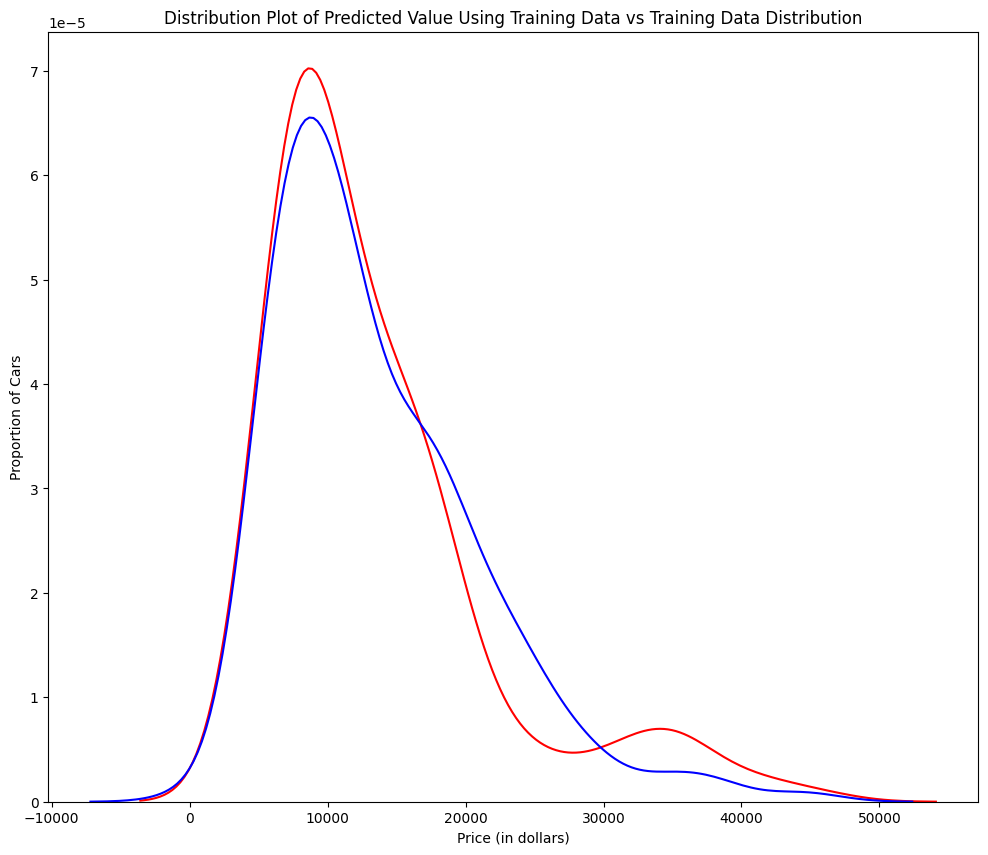

In [44]:
title = "Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution"
DistributionPlot(y_train, yhat_train, "Actual Values(Train)", "Predicted Values (Train)", title)

Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.


So far, the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.

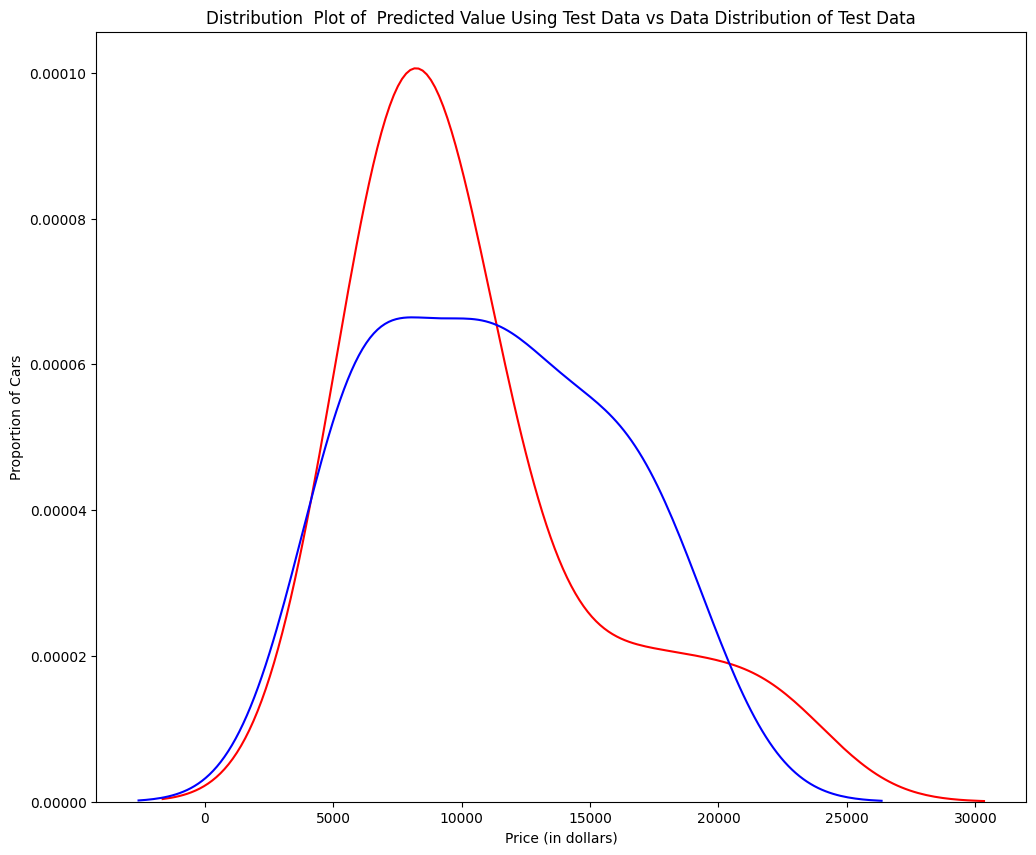

In [45]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Figure 2: Plot of predicted value using the test data compared to the actual values of the test data.


Comparing Figure 1 and Figure 2, it is evident that the distribution of the test data in Figure 1 is much better at fitting the data. This difference in Figure 2 is apparent in the range of 5000 to 15,000. This is where the shape of the distribution is extremely different. Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.

<h4>Overfitting</h4>
<p>Overfitting occurs when the model fits the noise, but not the underlying process. Therefore, when testing your model using the test set, your model does not perform as well since it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.</p>

Let's use 55 percent of the data for training and the rest for testing:

In [46]:
# use 55% of the data for training and 45% for testing:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

# We will perform a degree 5 polynomial transformation on the feature 'horsepower'
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])

pr

PolynomialFeatures(degree=5)

Let's create a Linear Regression Model 'poly' and train it.

In [47]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression()

We can see the output of our model using the method "predict." We assign the values to "yhat".

In [48]:
yhat = poly.predict(x_test_pr)  
yhat[:5]

array([ 6728.65571575,  7307.9879184 , 12213.78778443, 18893.24786348,
       19995.95173556])

Let's take the first five predicted values and compare it to the actual targets

In [49]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.65571575  7307.9879184  12213.78778443 18893.24786348]
True values: [ 6295. 10698. 13860. 13499.]


We will use the function "PollyPlot" that we defined at the beginning of the lab to display the training data, testing data, and the predicted function.

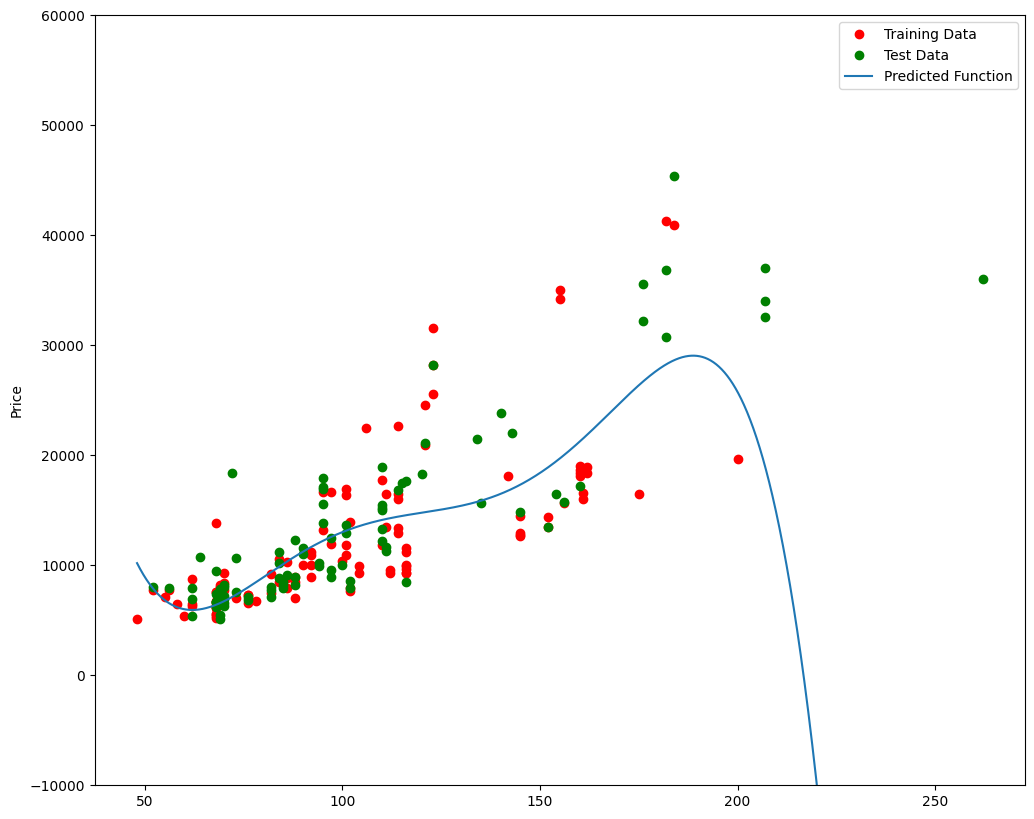

In [50]:
PollyPlot(x_train['horsepower'], x_test['horsepower'], y_train, y_test, poly,pr)

Figure 3: A polynomial regression model where red dots represent training data, green dots represent test data, and the blue line represents the model prediction.

We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points.

In [51]:
# R^2 of the training data
poly.score(x_train_pr, y_train)

0.5567716902123356

In [52]:
# R^2 of the test data
poly.score(x_test_pr, y_test)

-29.871340866226024

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87. The lower the R^2, the worse the model. A negative R^2 is a sign of overfitting

Let's see how the R^2 changes on the test data for different order polynomials and then plot the results:

Text(3, 0.75, 'Maximum R^2 ')

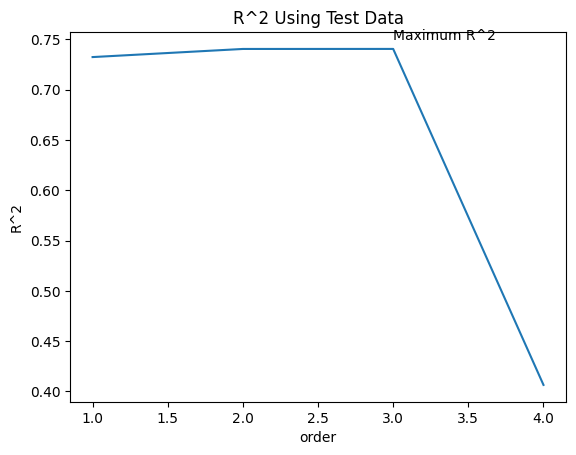

In [53]:
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')  

We see the R^2 gradually increases until an order three polynomial is used. Then, the R^2 dramatically decreases at an order four polynomial.

Function

In [56]:
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train['horsepower'], x_test['horsepower'], y_train, y_test, poly,pr)


The following interface allows you to experiment with different polynomial orders and different amounts of data.

In [57]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f(order, test_data)>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4a):</h1>

<b>We can perform polynomial transformations with more than one feature. Create a "PolynomialFeatures" object "pr1" of degree two.</b>

</div>

In [58]:
pr1 = PolynomialFeatures(degree=2)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4b & #4c): </h1>

<b> 
 Transform the training and testing samples for the features 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg'. Hint: use the method "fit_transform".</b>

 How many dimensions does the new feature have? Hint: use the attribute "shape".
</div>

In [60]:
x_train_pr1 = pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1 = pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

# Dimension
x_train_pr1.shape

(110, 15)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4d): </h1>

<b> 
Create a linear regression model "poly1". Train the object using the method "fit" using the polynomial features.</b>
</div>


In [62]:
poly1 = LinearRegression().fit(x_train_pr1, y_train)

poly1

LinearRegression()

 <div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4e): </h1>
<b>Use the method  "predict" to predict an output on the polynomial features, then use the function "DistributionPlot" to display the distribution of the predicted test output vs. the actual test data.</b>
</div>


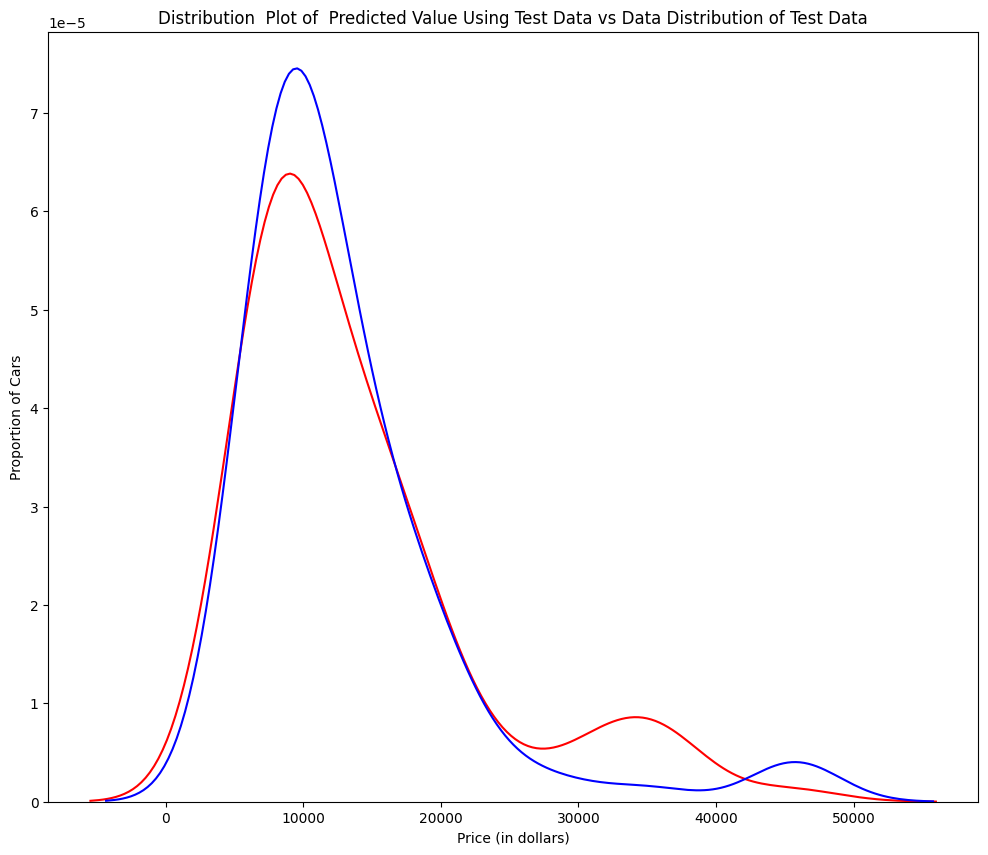

In [63]:
yhat_test1 = poly1.predict(x_test_pr1)

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4f): </h1>

<b>Using the distribution plot above, describe (in words) the two regions where the predicted prices are less accurate than the actual prices.</b>

</div>


### Summary
The predicted value is higher than actual value for cars where the price $10,000 range, conversely the predicted price is lower than the price cost in the $30,000 to $40,000 range. As such the model is not as accurate in these ranges.

# Part 3: Ridge Regression

In this section, we will review Ridge Regression and see how the parameter alpha changes the model. Just a note, here our test data will be used as validation data.

Let's perform a degree two polynomial transformation on our data.

In [64]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg', 'normalized-losses', 'symboling']])

x_test_pr = pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg', 'normalized-losses', 'symboling']])

#### Let's create a Ridge regression object, setting the regularization parameter (alpha) to 0.1

In [67]:
RigeModel = Ridge(alpha=1)

Like regular regression, you can fit the model using the method fit.

In [68]:
RigeModel.fit(x_train_pr, y_train)

Ridge(alpha=1)

Similarly, you can obtain a prediction:

In [ ]:
yhat = RigeModel.predict(x_test_pr)

Let's compare the first five predicted samples to our test set:

In [71]:
print("Predicted: ", yhat[:4])
print("test set: ", y_test[0:4].values)

Predicted:  [ 6728.65571575  7307.9879184  12213.78778443 18893.24786348]
test set:  [ 6295. 10698. 13860. 13499.]


We select the value of alpha that minimizes the test error. To do so, we can use a for loop. We have also created a progress bar to see how many iterations we have completed so far.

In [73]:
from tqdm import tqdm

Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

100%|██████████| 1000/1000 [00:09<00:00, 102.64it/s, Test Score=0.564, Train Score=0.859]


We can plot out the value of R^2 for different alphas:

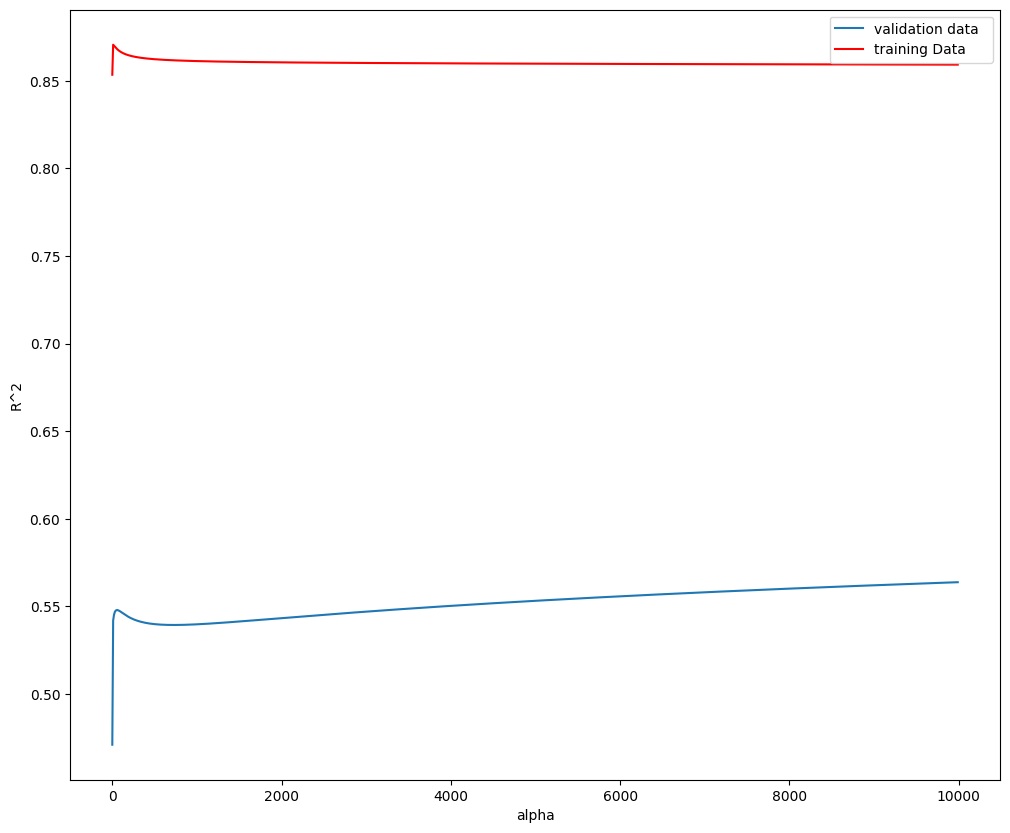

In [74]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

#### Summary
__Figure 4:__ The blue line represents the R^2 of the validation data, and the red line represents the R^2 of the training data. The x-axis represents the different values of Alpha.

Here the model is built and tested on the same data, so the training and test data are the same.

The red line in Figure 4 represents the R^2 of the training data. As alpha increases the R^2 decreases. Therefore, as alpha increases, the model performs worse on the training data

The blue line represents the R^2 on the validation data. As the value for alpha increases, the R^2 increases and converges at a point.

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #5): </h1>

Perform Ridge regression. Calculate the R^2 using the polynomial features, use the training data to train the model and use the test data to test the model. The parameter alpha should be set to 10.

</div>


In [75]:
RigeModel1 = Ridge(alpha=10)
RigeModel1.fit(x_train_pr, y_train)
RigeModel1.score(x_test_pr, y_test)

0.5418576440209322

# Part 4: Grid Search


The term alpha is a hyperparameter. Sklearn has the class __GridSearchCV__ to make the process of finding the best hyperparameter simpler.

Let's import __GridSearchCV__ from the module __model_selection__.

<i>from sklearn.model_selection import GridSearchCV</i>


In [77]:
# We create a dictionary of parameter values
parameter1 = [{'alpha':  [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]

parameter1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [80]:
# Create a Ridge Regression Object
RR = Ridge()

# Create a Ridge Grid Search (RGS) object
RGS = GridSearchCV(RR, parameter1, cv=4)

# Fit the model
RGS.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable BestRR as follows:

In [81]:
bestRR = RGS.best_estimator_
bestRR

Ridge(alpha=10000)

We now test our model on the test data:

In [82]:
# We now  test our model on the test data
bestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.841164983103615

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #6): </h1>
Perform a grid search for the alpha parameter and the normalization parameter, then find the best values of the parameters:
</div>


In [88]:
parameter2 = [{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

# Create a Ridge Grid Search object
grid_search_CV = GridSearchCV(Ridge(), parameter2, cv=4)  

# Fit/Train
grid_search_CV.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

# get best parameter
best_alpha = grid_search_CV.best_params_['alpha']   # 10000

best_ridge_model  = Ridge(alpha=best_alpha)

# Fit model with the best parameter
best_ridge_model.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

best_ridge_model.score(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

0.808722010262934